### Final Propensity matching results

In [1]:
%reset -f

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext Cython

In [3]:
%reload_ext Cython

In [4]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [5]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR, make_MYR_to_date
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )
import data_process
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import models, layers
import warnings
warnings.filterwarnings('ignore')
from utils import statistics_first_month, p_val, stat_matrices 
from path import col_seq_can_all, col_seq_can 
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type

In [6]:
# #setup cython
# #for cython build if needed -> cd to /modules folder and then run
# %cd ..
# !python3 setup.py build_ext --inplace
# %cd ./causal_data_creation/canary_application/

In [7]:
%config Completer.use_jedi = False

### Load pre matching data

In [8]:
pp_str = 'Pre_Matching_DATA/'
Path("./"+pp_str).mkdir(exist_ok=True)

In [9]:
# %%time
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/treated2.p ./Pre_Matching_DATA/treated2.p; 
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/controls.p ./Pre_Matching_DATA/controls.p;
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/pmpm.p ./Pre_Matching_DATA/pmpm.p;
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/tempHybridSelectionMoreData/random.p ./Pre_Matching_DATA/random.p;

In [10]:
treated = pd.read_pickle(pp_str+'treated2Past2.p')
controls = pd.read_pickle(pp_str+'controlsPast.p')
controls2  = controls[controls['HasPast'] == 1].reset_index(drop = True)
pmpm =pd.read_pickle(pp_str+'pmpm.p')
random_controls = pd.read_pickle(pp_str+'random.p')

In [11]:
pmpm.MBR_GNDR.replace({"F":0,"M":1}, inplace=True)

In [12]:
treated.shape, treated.MYR.min(), treated.MYR.max()

((22364, 92), 201710, 202107)

In [13]:
controls.shape, controls.MYR.min(), controls.MYR.max()

((9582196, 92), 201701, 202107)

In [14]:
pmpm.shape, pmpm.MYR.min(), pmpm.MYR.max()

((9650961, 91), 201701, 202107)

# Check continuity and take average of 1 year history

### Treated

In [15]:
# def get_treated_agg(treated, pmpm):
    
#     #get one year before dates
#     treated_history = pmpm[pmpm.PERS_ID.isin(treated.PERS_ID)]
#     treated.drop(['MEDICAID_LOB'], axis=1, inplace=True)
#     treated['MYR_12'] = treated.MYR.apply(data_process.get_one_year_before, offset_month=12)
    
#     treated_aggregate = pd.DataFrame(columns=col_seq_can_all)
#     for i, (index, row) in tqdm(enumerate(treated.iterrows())):
#         pid = row.PERS_ID
#         myr = row.MYR
#         old_myr = row.MYR_12
#         history = treated_history.query("PERS_ID==@pid & MYR>=@old_myr & MYR<=@myr")
#         agg_data = history[col_seq_can_all].mean()
#         agg_data.PERS_ID = str(int(row.PERS_ID))
#         agg_data.MYR     = int(row.MYR)
#         treated_aggregate = pd.concat([treated_aggregate, pd.DataFrame(agg_data).T], axis=0)
            
#     treated_aggregate.PERS_ID = treated_aggregate.astype(int).astype(str)
#     treated_aggregate.MYR = treated_aggregate.MYR.astype(int)
    
#     treated_aggregate = treated_aggregate.reset_index(drop=True)
    
#     return treated_aggregate
    

In [16]:
# %%time
# treated_aggregate = get_treated_agg(treated.copy(), pmpm.copy())
# treated_aggregate.to_pickle("./Final/Data/Common/treated_aggregated_filtered_final_g.p")

In [17]:
sorted_months = treated.MYR.sort_values().unique()

In [18]:
sorted_months

array([201710, 201711, 201712, 201801, 201802, 201803, 201804, 201805,
       201806, 201807, 201808, 201809, 201810, 201811, 201812, 201901,
       201902, 201903, 201904, 201905, 201906, 201907, 201908, 201909,
       201910, 201911, 201912, 202001, 202002, 202003, 202004, 202005,
       202006, 202007, 202008, 202009, 202010, 202011, 202012, 202101,
       202102, 202103, 202104, 202105, 202106, 202107])

In [19]:
treated_aggregate = pd.read_pickle("./Final/Data/Common/treated_aggregated_filtered_final_g.p") #goes into matching as tr_agg

In [20]:
#controls_aggregate = data_process.get_average_final_record(controls2.copy(), sorted_months, pmpm[col_seq_can_all].copy())
#controls_aggregate.to_pickle("./Final/Data/Common/controls_aggregated_filtered_final_g.p")

In [21]:
controls_aggregate = pd.read_pickle("./Final/Data/Common/controls_aggregated_filtered_final_g.p")

In [22]:
controls_aggregate.shape, controls2.shape

In [23]:
treated_original = treated[treated.set_index(['PERS_ID','MYR']).index.isin(treated_aggregate.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)
controls_original = controls2[controls2.set_index(['PERS_ID','MYR']).index.isin(controls_aggregate.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)

In [24]:
del treated, controls, controls2

In [25]:
# !aws s3 cp ./Final/Data/PCA/treated_aggregated_filtered_final.p s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/Agg_Data_Common/treated_agg.p --acl bucket-owner-full-control
# !aws s3 cp ./Final/Data/PCA/controls_aggregated_filtered_final.p s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/Agg_Data_Common/controls_agg.p --acl bucket-owner-full-control

# Load Model and Pick Columns for Matching

In [26]:
treated_aggregate[['ALLOW_AMT', 'ALLOW_IP', 'ALLOW_ER']] = treated_aggregate[['ALLOW_AMT', 'ALLOW_IP', 'ALLOW_ER']].apply(data_process.log_)
controls_aggregate[['ALLOW_AMT', 'ALLOW_IP', 'ALLOW_ER']] = controls_aggregate[['ALLOW_AMT', 'ALLOW_IP', 'ALLOW_ER']].apply(data_process.log_)

In [27]:
treated_aggregate.head()

PERS_ID     MYR  AGE_AT_MIDMONTH  LOB  MBR_GNDR  ALLOW_AMT   ALLOW_ER   ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  \
0  2602482  201908        80.769231  1.0       0.0   5.630384 -16.118096 -16.118096      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0              1.0   3.307692                    0.0          0.0              0.0     0.846154                1.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0           0.538462         0.923077             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
1  2602482  201909        80.846154  1.0       0.0   5.902843 -16.118096 -16.118096      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0              1.0   3.153846                    0.0          0.0              0.0     0.769231                1.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0           0.461538         0.923077             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
2  2602482  201910        80.923077  1.0       0.0   5.930203 -16.118096 -16.118096      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0              1.0   3.000000                    0.0          0.0              0.0     0.692308                1.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0           0.384615         0.923077             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
3  2602482  201911        81.076923

In [28]:
model = models.load_model(pp_str+"TF_Latent_Model_m6_Canary_stacked_AE_logfixed", compile=False)

In [29]:
latent_cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16']

In [30]:
onset = "CC_DIABETES"
cols_to_keep = ["PERS_ID", "MYR", 'AGE_AT_MIDMONTH', 'MBR_GNDR',  onset]
extra_cols = ['IP_BIN6', 'ER_BIN6','LOB']

In [31]:
treated_latent = data_process.transform_features_with_NN(model, treated_aggregate[col_seq_can_all].copy(), cols_to_keep, latent_dim=16)
treated_latent1 = treated_original[cols_to_keep+extra_cols]
treated_latent = pd.concat([treated_latent1, treated_latent.loc[:,'x1':]], axis=1)

In [32]:
controls_latent = data_process.transform_features_with_NN(model, controls_aggregate[col_seq_can_all].copy(), cols_to_keep, latent_dim=16)
controls_latent1 = controls_original[cols_to_keep+extra_cols]
controls_latent = pd.concat([controls_latent1, controls_latent.loc[:,'x1':]], axis=1)

In [33]:
del treated_latent1, controls_latent1

In [34]:
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

all_columns1 = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB',
                                                         'IP_BIN', 'ER_BIN', 'ACUTE', 'IP_C', 'ER_C', 'ACUTE_C','IP_BIN2', 'ER_BIN2']))

all_columns2 = list(set(all_columns1)-set(['IP_BIN6', 'ER_BIN6', 'LOB']))

In [35]:
controls_latent.shape, controls_original.shape

# Matching

In [36]:
%%time
match_on = latent_cols
hier_cols = ['IP_BIN6', 'ER_BIN6']
hier_range = [1,1]
exact_match_dict = {'IP_BIN6':[0,1,2], 'ER_BIN6':[0,1,2], 'LOB':None}
nnr_func_args = {'match_on':match_on, 'hier_cols':None,
                        'hier_range':None, 'neighbors_per_treated': 5,
                 'onset': "CC_DIABETES", "onset_val" : 0, 'exact_match': False, 'exact_match_dict': None}
matched0, matched_data0 = matched_population(treated_latent.copy(), 
                                           controls_latent.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

Mathcing Function: nearest_neighbor_func
hERE
After filtering control ids are:263545 before they were:293527


1367it [21:27,  1.06it/s]

CPU times: user 32min 13s, sys: 22min 30s, total: 54min 43s
Wall time: 21min 30s


In [37]:
# matched0.to_pickle("matched0.p")
# matched_data0.to_pickle("matched_data0.p")

In [38]:
controls = pd.read_pickle(pp_str+'controlsPast.p')

In [39]:
controls_all =  pd.DataFrame()
matched_data1 = pd.DataFrame()
controls22 = controls.copy()
controls22 = controls22.set_index('PERS_ID', drop = False)

In [40]:
%%time
counter = 0

for (key, month), val in tqdm(matched0.items()):
    val['RD'] = val.MYR
    first = controls22.loc[val['PERS_ID']].reset_index(drop = True)
    
    new_dat = pd.merge(first, val[['PERS_ID','RD']],  on = 'PERS_ID',)
    new_dat['PERS_ID2'] = new_dat.PERS_ID
    new_dat['PERS_ID'] = new_dat['PERS_ID']+str(counter)    
    filt = new_dat.MYR >= new_dat.RD
    new_dat2 = new_dat[filt].reset_index(drop = True)
    
    #control_groups[group] = new_dat2
    matched_data1 = pd.concat((matched_data1, new_dat2), ignore_index = True)
    controls_all = pd.concat((controls_all, new_dat), ignore_index = True)
    counter += 1

100%|██████████| 1367/1367 [09:18<00:00,  2.45it/s]

CPU times: user 7min 52s, sys: 1min 27s, total: 9min 19s
Wall time: 9min 18s


In [41]:
matched_data0

PERS_ID     MYR  AGE_AT_MIDMONTH  MBR_GNDR  CC_DIABETES  IP_BIN6  ER_BIN6  LOB        x1        x2        x3         x4        x5        x6        x7        x8        x9       x10       x11       x12       x13       x14        x15        x16
0      2624977  201908               77         1          0.0      0.0      0.0    1 -0.000837  7.018561  0.006293  33.112106  0.348582 -0.315954  0.096256 -0.377658 -0.320309 -0.183376  0.478327 -0.096891 -0.081462 -0.233809  33.475418  21.752037
1      2624977  201909               77         1          0.0      0.0      0.0    1 -0.000966  7.109737  0.006015  33.511299  0.352148 -0.319248  0.097568 -0.381868 -0.323890 -0.190646  0.484142 -0.097770 -0.077470 -0.236626  33.878094  22.015699
2      2624977  201910               77         1          0.0      0.0      0.0    1 -0.000914  7.063524  0.006140  33.307911  0.350333 -0.317562  0.096904 -0.379764 -0.322103 -0.186888  0.481160 -0.097354 -0.079466 -0.235216  33.672840  21.881477
3      2624977  201911               77         1          0.0      0.0      0.0    1 -0.000927  7.071886  0.006110  33.344666  0.350650 -0.317858  0.097032 -0.380151 -0.322430 -0.187527  0.481690 -0.097435 -0.079099 -0.235473  33.709862  21.905733
4      2624977  201912               77         1          0.0      0.0      0.0    1 -0.000938  7.089159  0.006078  33.420158  0.351359 -0.318512  0.097254 -0.380943 -0.323119 -0.189009  0.482820 -0.097613 -0.078324 -0.235998  33.786152  21.955524
...        ...     ...              ...       ...          ...      ...      ...  ...       ...       ...       ...        ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...        ...        ...
90600  5017132  202103               73         1          0.0      0.0      0.0    1  0.019565 -0.516208  0.034320   0.383718  0.054840 -0.050863 -0.008720 -0.015120 -0.023205  0.409128 -0.000187 -0.013962 -0.418770  0.009792   0.462558   0.077527
90601  5017132  202104               73         1          0.0      0.0      0.0    1  0.019505 -0.539134  0.034550   0.283910  0.053682 -0.049634 -0.008675 -0.013672 -0.021981  0.411793 -0.002027 -0.013297 -0.420517  0.010482   0.363211   0.011227
90602  5017132  202105               73         1          0.0      0.0      0.0    1  0.019519 -0.533916  0.034501   0.306670  0.053935 -0.049904 -0.008671 -0.013992 -0.022256  0.411203 -0.001609 -0.013444 -0.420109  0.010338   0.385827   0.026316
90603  5017132  202106               73         1          0.0      0.0      0.0    1  0.019057 -0.605303  0.035144  -0.009461  0.050031 -0.045605 -0.008341 -0.009210 -0.017978  0.420725 -0.007738 -0.011033 -0.425722  0.012715   0.071604  -0.183863
90604  5017132  202107               73         1          0.0      0.0      0.0    1  0.019133 -0.580822  0.034904   0.097798  0.051263 -0.046932 -0.008379 -0.010737 -0.019287  0.417791 -0.005755 -0.011727 -0.423874  0.012000   0.178553  -0.112685

[90605 rows x 24 columns]

In [42]:
matched_data1

PERS_ID     MYR  MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT MEDICAID_LOB  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  \
0         26249770  201908         1               77        111     Medicare       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          1.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          5                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                1.0              1.0             0.0           0.0          1.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0   
1         26249770  201909         1               77        227     Medicare       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          1.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          5                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                1.0              1.0             0.0           0.0          1.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0   
2         26249770  201910         1               77         86     Medicare       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          1.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          5                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                1.0              1.0             0.0           0.0          1.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0   
3         26249770  201911         

In [43]:
def get_data(data_struct):
    keys = list(data_struct)
    dat1 = pd.DataFrame()
    for key in keys:
        dat1 = pd.concat([dat1, data_struct[key]], ignore_index=True)
    return dat1

In [44]:
matched_controls_5N = get_data(matched0)

### Result Folder Base

In [45]:
data_base = "./Final/Data/AE_nofilter_g/"
result_base = "./Final/results/AE_nofilter_g/"
stats_base = "./Final/results/AE_nofilter_g/stats_matching/"
Path(data_base).mkdir(exist_ok=True)
Path(result_base).mkdir(exist_ok=True)
Path(stats_base).mkdir(exist_ok=True)

In [46]:
matched_controls_5N.to_pickle(data_base+"matched0.p")

In [47]:
controls_all.to_pickle(data_base+'controls_all.p')

In [48]:
matched_data0.to_pickle(data_base+"matched_controls_latent_from_algo.p")

In [49]:
matched_data1.to_pickle(data_base+"matched_controls_latent_after_process.p")

### Calculate matched controls agg and matched controls original 

In [50]:
# matched_controls_original = controls[controls.set_index(['PERS_ID','MYR']).index.isin(matched_data1.set_index(['PERS_ID2','MYR']).index)].reset_index(drop=True)

In [51]:
matched_controls_original = matched_data1

In [52]:
matched_controls_original.to_pickle(data_base+"matched_controls_original.p")

In [53]:
matched_controls_aggregate = controls_aggregate[controls_aggregate.set_index(['PERS_ID','MYR']).index.isin(matched_data0.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)

In [54]:
matched_controls_aggregate.to_pickle(data_base+"matched_controls_aggregate.p")

### List containing all numerical columns

In [55]:
all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))

# Statistics First Month Original

In [56]:
# del controls, controls2

In [57]:
treated = pd.read_pickle(pp_str+'treated2Past2.p')

In [58]:
%%time
tr_desc0, treated_first_month = statistics_first_month(treated, all_columns, return_array = True)
con_desc0, controls_first_month = statistics_first_month(matched_controls_original, all_columns, return_array = True)

pmpm_desc = statistics_first_month(pmpm, all_columns)
random_desc = statistics_first_month(random_controls, all_columns)

conds_first, full_first = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = columns_to_match)
conds_firstAllCols, full_firstAllCols = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = all_columns)


CPU times: user 2min 33s, sys: 17.3 s, total: 2min 51s
Wall time: 2min 51s


In [59]:
conds_first

Treated Matched Controls    Test-TC               General Population      Random
                       mean             mean     t-stat          pval               mean        mean
AGE_AT_MIDMONTH   50.738113        49.899781   1.563361  1.180062e-01          44.310976   47.606399
ALLOW_AMT        712.070227       690.329188   0.263228  7.923818e-01        1065.926022  648.802692
MBR_GNDR           0.212143         0.409071 -13.878595  2.631336e-43           0.442749    0.431056
CC_TOBACCO         0.061448         0.104609  -4.919337  8.852745e-07           0.074202    0.098400
CC_PRESSURE        0.001463         0.005999  -2.120069  3.403021e-02           0.007390    0.006602
CC_OBESITY         0.498903         0.281785  15.977085  1.312524e-56           0.108841    0.228035
CC_HYPERTENSION    0.342356         0.294221   3.539968  4.023946e-04           0.207717    0.249365
CC_HYPOTHYROID     0.100951         0.073299   3.484235  4.961235e-04           0.047300    0.063484
CC_DX_CNT          2.912217         2.662473   3.436346  5.925422e-04           1.824419    2.343702
ACUTE2             0.039503         0.045794  -0.965585  3.342803e-01           0.063258    0.051549
ACUTE6             0.115582         0.146013  -2.280061  2.262962e-02           0.063258    0.153377
IP_BIN6            0.029993         0.040527  -1.470213  1.415426e-01           0.020587    0.046851
ER_BIN6            0.091441         0.112802  -1.860288  6.288061e-02           0.047286    0.116176
LOB                0.954645         0.812290  13.110253  7.065023e-39           0.755775    0.787836

In [60]:
conds_first.to_csv(result_base+"stats_matching/conds_original_first.csv", index=True, header=True)
full_first.to_csv(result_base+"stats_matching/full_original_first.csv", index=True, header=True)
conds_firstAllCols.to_csv(result_base+"stats_matching/conds_original_first_allcols.csv", index=True, header=True)
full_firstAllCols.to_csv(result_base+"stats_matching/full_original_first_allcols.csv", index=True, header=True)

# Latent First Month

In [61]:
%%time
tr_desc0_l, treated_first_month_l = statistics_first_month(treated_latent, latent_cols, return_array = True)
con_desc0_l, controls_first_month_l = statistics_first_month(matched_data0, latent_cols, return_array = True)

conds_lat, full_lat = stat_matrices(tr_desc0_l, con_desc0_l, tr_desc0_l, tr_desc0_l, columns = latent_cols)


CPU times: user 2.54 s, sys: 0 ns, total: 2.54 s
Wall time: 2.54 s


In [62]:
conds_lat

Treated Matched Controls   Test-TC           General Population     Random
          mean             mean    t-stat      pval               mean       mean
x1    0.013518         0.013539 -0.118889  0.905366           0.013518   0.013518
x2    1.780845         1.784473 -0.066461  0.947012           1.780845   1.780845
x3    0.026278         0.026245  0.165103  0.868867           0.026278   0.026278
x4   10.365922        10.382336 -0.069514  0.944582          10.365922  10.365922
x5    0.146110         0.146308 -0.093682  0.925364           0.146110   0.146110
x6   -0.133550        -0.133736  0.097399  0.922412          -0.133550  -0.133550
x7    0.023570         0.023597 -0.035360  0.971794           0.023570   0.023570
x8   -0.123341        -0.123456  0.039580  0.968429          -0.123341  -0.123341
x9   -0.112330        -0.112432  0.043854  0.965022          -0.112330  -0.112330
x10   0.232375         0.232159  0.045748  0.963512           0.232375   0.232375
x11   0.144109         0.144291 -0.049727  0.960341           0.144109   0.144109
x12  -0.038525        -0.038517 -0.007819  0.993762          -0.038525  -0.038525
x13  -0.315022        -0.315019 -0.000859  0.999315          -0.315022  -0.315022
x14  -0.064786        -0.064951  0.094997  0.924319          -0.064786  -0.064786
x15  10.523558        10.540260 -0.070130  0.944092          10.523558  10.523558
x16   6.674597         6.685568 -0.070137  0.944087           6.674597   6.674597

In [63]:
conds_lat[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_lat_first.csv", index=True, header=True)
full_lat[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_lat_first.csv", index=True, header=True)

# Agg First Month

In [64]:
%%time
without_custom_cols = [cols for cols in all_columns if cols not in ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ER_BIN', 'IP_BIN6', 'ACUTE6', 'ACUTE_C', 'ACUTE', 'IP_BIN', 'PREGNANCY', 'ER_BIN6', 'IP_C', 'ER_C']]
selected_without_custom_cols = [cols for cols in columns_to_match if cols not in ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ER_BIN', 'IP_BIN6', 'ACUTE6', 'ACUTE_C', 'ACUTE', 'IP_BIN', 'PREGNANCY', 'ER_BIN6', 'IP_C', 'ER_C']]

tr_desc0_agg, treated_agg_first_month = statistics_first_month(treated_aggregate, without_custom_cols, return_array = True)
con_desc0_agg, controls_agg_first_month = statistics_first_month(matched_controls_aggregate, without_custom_cols, return_array = True)

conds_agg, full_agg = stat_matrices(tr_desc0_agg, con_desc0_agg, tr_desc0_agg, tr_desc0_agg, columns = selected_without_custom_cols)
conds_aggAllCols, full_aggAllCols = stat_matrices(tr_desc0_agg, con_desc0_agg, tr_desc0_agg, tr_desc0_agg, columns = without_custom_cols)


CPU times: user 2.92 s, sys: 0 ns, total: 2.92 s
Wall time: 2.92 s


In [65]:
conds_agg[['Treated', 'Matched Controls', 'Test-TC']].round(3)

Treated Matched Controls Test-TC       
                   mean             mean  t-stat   pval
AGE_AT_MIDMONTH  50.261           49.293   1.804  0.071
ALLOW_AMT         5.772            5.405   5.488  0.000
MBR_GNDR          0.212            0.410 -13.915  0.000
CC_TOBACCO        0.055            0.099  -5.417  0.000
CC_PRESSURE       0.001            0.006  -2.164  0.030
CC_OBESITY        0.442            0.257  14.919  0.000
CC_HYPERTENSION   0.320            0.282   3.046  0.002
CC_HYPOTHYROID    0.090            0.072   2.448  0.014
CC_DX_CNT         2.649            2.520   1.874  0.061
LOB               0.954            0.810  13.277  0.000

In [66]:
conds_agg[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg_first.csv", index=True, header=True)
full_agg[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg_first.csv", index=True, header=True)
conds_aggAllCols[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg_first_allcols.csv", index=True, header=True)
full_aggAllCols[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg_first_allcols.csv", index=True, header=True)

# Stat all Original

In [67]:
%%time
tr_desc0A = treated[all_columns].describe().loc[['mean', 'std', 'count']].T
tr_desc0A['count'] = tr_desc0A['count'].astype(int)

con_desc0A = matched_controls_original[all_columns].describe().loc[['mean', 'std', 'count']].T
con_desc0A['count'] = con_desc0A['count'].astype(int)

pmpm_descA = pmpm[all_columns].describe().loc[['mean', 'std', 'count']].T
pmpm_descA['count'] = pmpm_descA['count'].astype(int)

random_descA = random_controls[all_columns].describe().loc[['mean', 'std', 'count']].T
random_descA['count'] = random_descA['count'].astype(int)

conds, full = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = columns_to_match)
conds_AllCols, full_AllCols = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = all_columns)


CPU times: user 29.2 s, sys: 2.39 s, total: 31.6 s
Wall time: 31.6 s


In [68]:
conds.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   51.079           52.128  -7.996  0.000             50.379   50.236
ALLOW_AMT        812.538          780.323   0.982  0.326            857.856  706.609
MBR_GNDR           0.196            0.399 -57.746  0.000              0.433    0.429
CC_TOBACCO         0.064            0.107 -19.563  0.000              0.102    0.100
CC_PRESSURE        0.003            0.008  -8.182  0.000              0.013    0.008
CC_OBESITY         0.533            0.319  61.110  0.000              0.255    0.286
CC_HYPERTENSION    0.332            0.329   0.877  0.380              0.329    0.300
CC_HYPOTHYROID     0.098            0.081   8.066  0.000              0.078    0.075
CC_DX_CNT          3.049            2.969   4.275  0.000              2.955    2.759
ACUTE2             0.032            0.048  -9.461  0.000              0.060    0.050
ACUTE6             0.101            0.144 -12.849  0.000              0.168    0.150
IP_BIN6            0.026            0.045 -10.666  0.000              0.055    0.049
ER_BIN6            0.079            0.106  -9.773  0.000              0.122    0.111
LOB                0.955            0.821  50.756  0.000              0.802    0.803

In [69]:
conds.to_csv(result_base+"stats_matching/conds_original.csv", index=True, header=True)
full.to_csv(result_base+"stats_matching/full_original.csv", index=True, header=True)
conds_AllCols.to_csv(result_base+"stats_matching/conds_original_allcols.csv", index=True, header=True)
full_AllCols.to_csv(result_base+"stats_matching/full_original_allcols.csv", index=True, header=True)

# Latent Alltime

In [70]:
%%time
tr_desc0_latA = treated_latent[latent_cols].describe().loc[['mean', 'std', 'count']].T
tr_desc0_latA['count'] = tr_desc0_latA['count'].astype(int)

con_desc0_latA = matched_data0[latent_cols].describe().loc[['mean', 'std', 'count']].T
con_desc0_latA['count'] = con_desc0_latA['count'].astype(int)

conds_latA, full_latA = stat_matrices(tr_desc0_latA, con_desc0_latA, tr_desc0_latA, tr_desc0_latA, columns = latent_cols)


CPU times: user 138 ms, sys: 1.31 ms, total: 140 ms
Wall time: 140 ms


In [71]:
conds_latA

Treated Matched Controls    Test-TC                General Population     Random
          mean             mean     t-stat           pval               mean       mean
x1    0.013309         0.014882 -22.533178  3.475722e-112           0.013309   0.013309
x2    1.822448         1.741504   5.316822   1.057952e-07           1.822448   1.822448
x3    0.026218         0.025327  15.804642   3.321235e-56           0.026218   0.026218
x4   10.539924        10.269700   4.136687   3.526113e-05          10.539924  10.539924
x5    0.147624         0.145908   2.966576   3.011994e-03           0.147624   0.147624
x6   -0.134977        -0.132953  -3.852037   1.172037e-04          -0.134977  -0.134977
x7    0.023594         0.028757 -22.028136  2.608492e-107           0.023594   0.023594
x8   -0.126536        -0.108892 -18.277841   1.592162e-74          -0.126536  -0.126536
x9   -0.114836        -0.101825 -17.129687   1.079461e-65          -0.114836  -0.114836
x10   0.227155         0.255553 -18.118311   2.903322e-73           0.227155   0.227155
x11   0.147729         0.131526  14.339792   1.356389e-46           0.147729   0.147729
x12  -0.040084        -0.026486 -28.479852  8.895312e-178          -0.040084  -0.040084
x13  -0.311368        -0.335558  22.444426  2.545093e-111          -0.311368  -0.311368
x14  -0.065871        -0.066227   0.759936   4.472944e-01          -0.065871  -0.065871
x15  10.698804        10.428367   4.104992   4.046133e-05          10.698804  10.698804
x16   6.790465         6.604521   4.291262   1.778079e-05           6.790465   6.790465

In [72]:
conds_latA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_lat_allcols.csv", index=True, header=True)
full_latA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_lat_allcols.csv", index=True, header=True)

# Agg alltime

In [73]:
%%time
tr_desc0_aggA = treated_aggregate[without_custom_cols].describe().loc[['mean', 'std', 'count']].T
tr_desc0_aggA['count'] = tr_desc0_aggA['count'].astype(int)

con_desc0_aggA = matched_controls_aggregate[without_custom_cols].describe().loc[['mean', 'std', 'count']].T
con_desc0_aggA['count'] = con_desc0_aggA['count'].astype(int)

conds_aggA, full_aggA = stat_matrices(tr_desc0_aggA, con_desc0_aggA, tr_desc0_agg, tr_desc0_agg, columns = selected_without_custom_cols)
conds_aggAllColsA, full_aggAllColsA = stat_matrices(tr_desc0_aggA, con_desc0_aggA, tr_desc0_agg, tr_desc0_agg, columns = without_custom_cols)



CPU times: user 608 ms, sys: 0 ns, total: 608 ms
Wall time: 607 ms


In [74]:
conds_aggA

Treated Matched Controls    Test-TC               General Population     Random
                      mean             mean     t-stat          pval               mean       mean
AGE_AT_MIDMONTH  50.584865        51.852255  -9.641930  5.422740e-22          50.260886  50.260886
ALLOW_AMT         5.740478         5.594900  10.021197  1.258346e-23           5.772460   5.772460
MBR_GNDR          0.196074         0.399547 -57.630406  0.000000e+00           0.212143   0.212143
CC_TOBACCO        0.062775         0.105136 -20.083305  1.481882e-89           0.054730   0.054730
CC_PRESSURE       0.001861         0.007382 -10.211072  1.812873e-24           0.001407   0.001407
CC_OBESITY        0.512188         0.313255  60.606869  0.000000e+00           0.442005   0.442005
CC_HYPERTENSION   0.327053         0.333333  -1.928670  5.377436e-02           0.320176   0.320176
CC_HYPOTHYROID    0.093022         0.080589   6.543114  6.050699e-11           0.089568   0.089568
CC_DX_CNT         2.891615         2.934698  -2.411819  1.587475e-02           2.648890   2.648890
LOB               0.956211         0.823092  50.673413  0.000000e+00           0.954162   0.954162

In [75]:
conds_aggA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg.csv", index=True, header=True)
full_aggA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg.csv", index=True, header=True)
conds_aggAllColsA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg_allcols.csv", index=True, header=True)
full_aggAllColsA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg_allcols.csv", index=True, header=True)

# Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Figures for the paper

In [76]:
columns_to_match

['AGE_AT_MIDMONTH',
 'ALLOW_AMT',
 'MBR_GNDR',
 'CC_TOBACCO',
 'CC_PRESSURE',
 'CC_OBESITY',
 'CC_HYPERTENSION',
 'CC_HYPOTHYROID',
 'CC_DX_CNT',
 'ACUTE2',
 'ACUTE6',
 'IP_BIN6',
 'ER_BIN6',
 'LOB']

In [77]:
mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                                     'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                                      'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness']))
mapping2 = dict(zip(all_columns, all_columns))
#mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [78]:
base_path =  result_base
p = Path(base_path)
p.mkdir(parents = True, exist_ok = True)

In [79]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

#### Remove %%capture to see output

In [80]:
from diabetes_onset_plotter import plot_hist, save_arrays, save_arrays2


In [81]:
%%capture

dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping2, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_all/',
                dist_plot_args = dist_plot_args)

In [82]:
%%capture
dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_selection/',
                dist_plot_args = dist_plot_args)

# Standardized Means Graph

In [83]:
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

In [84]:
tr_desc0, treated_first_month = statistics_first_month(treated, columns_to_match, return_array = True)

In [85]:
con_desc0, controls_first_month = statistics_first_month(matched_controls_original, columns_to_match, return_array = True)

In [86]:
controls_original.shape, matched_controls_original.shape

In [87]:
un_controls_ = controls_original[columns_to_match].describe().loc[['mean', 'std', 'count']].T

In [88]:
un_controls_all = controls_original[all_columns].describe().loc[['mean', 'std', 'count']].T

In [89]:
un_controls_all.to_csv(result_base+"stats_matching/unmatched_all_cols_stats.csv", index=True, header=True)

In [90]:
pooled = (tr_desc0['std']* len(treated) + un_controls_['std']*len(controls_original))/(len(treated)+len(controls_original))

In [91]:
stdMeans = pd.DataFrame()
stdMeans['Treated'] = tr_desc0['mean']/pooled
stdMeans['Controls'] = un_controls_['mean']/pooled
stdMeans['MControls'] = con_desc0['mean']/pooled

In [92]:
stdMeans

Treated  Controls  MControls
AGE_AT_MIDMONTH  2.661907  2.757797   2.617926
ALLOW_AMT        0.149042  0.188666   0.144492
MBR_GNDR         0.428267  0.876618   0.825818
CC_TOBACCO       0.198635  0.347112   0.338152
CC_PRESSURE      0.011972  0.124699   0.049085
CC_OBESITY       1.084936  0.659670   0.612782
CC_HYPERTENSION  0.707053  0.775361   0.607643
CC_HYPOTHYROID   0.353205  0.313860   0.256457
CC_DX_CNT        0.963439  1.112345   0.880817
ACUTE2           0.157228  0.226504   0.182268
ACUTE6           0.222796  0.333188   0.281456
IP_BIN6          0.101681  0.201059   0.137394
ER_BIN6          0.214092  0.289287   0.264104
LOB              2.493946  2.144663   2.122051

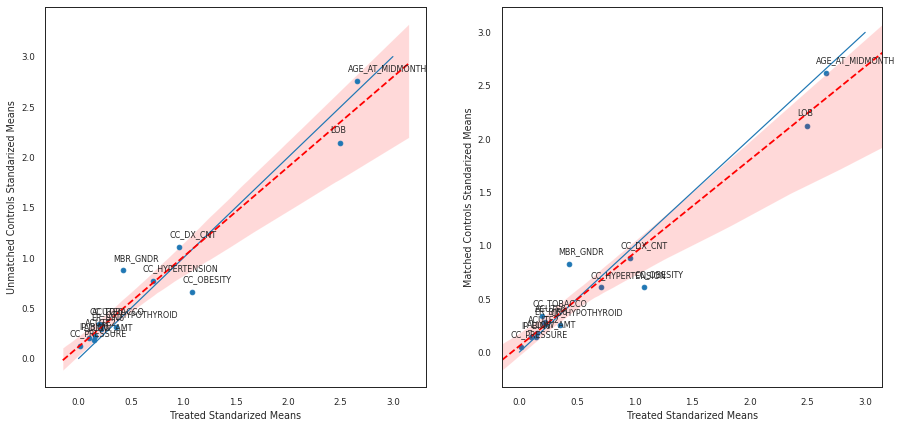

In [93]:
fig, ax = plt.subplots(1,2, figsize = (15,7))
ax[0].plot([0,3], [0, 3])
ax[1].plot([0,3], [0, 3])
ax[0].set_xlabel('Treated Standarized Means')
ax[0].set_ylabel('Unmatched Controls Standarized Means')
sns.regplot(stdMeans['Treated'].values, stdMeans['Controls'].values,scatter = False, ax = ax[0],line_kws={"color": "red","linestyle" : '--'
})

ax[0].scatter(stdMeans['Treated'], stdMeans['Controls'])
ax[1].scatter(stdMeans['Treated'], stdMeans['MControls'])
ax[1].set_xlabel('Treated Standarized Means')
ax[1].set_ylabel('Matched Controls Standarized Means')
sns.regplot(stdMeans['Treated'].values, stdMeans['MControls'].values, scatter = False,ax = ax[1], line_kws={"color": "red","linestyle" : '--'
})
for i, name in enumerate(list(stdMeans.index)):
    ax[0].annotate(name, (stdMeans['Treated'].iloc[i],stdMeans['Controls'].iloc[i]), fontsize = 'small',
                   textcoords = 'offset points',xytext = (-10,10))
    ax[1].annotate(name, (stdMeans['Treated'].iloc[i],stdMeans['MControls'].iloc[i]),fontsize = 'small',
                   textcoords = 'offset points', xytext = (-10,10))

fig.savefig(result_base+"figures/std_means_graph.png")
fig.show()

# Ratio Stats

In [94]:
disease_cols = [cols for cols in treated.columns if "CC" in cols and cols!='CC_DX_CNT']
other_binary_cols = ['MBR_GNDR', 'LOB', 'PREGNANCY', 'IP_BIN', 'ER_BIN', 'ACUTE']
binary_cols = other_binary_cols + disease_cols 
restricted_cols = ['PERS_ID', 'MYR', 'MEDICAID_LOB']
continuous_cols = [cols for cols in treated.columns if cols not in binary_cols + restricted_cols]

In [95]:
def calculate_continuous_d(t, c):
    Xt = np.mean(t)
    Xc = np.mean(c)
    St = np.std(t)
    Sc = np.std(c)
    d = np.abs((Xt-Xc)/(np.sqrt((St**2 + Sc**2)/2)))
    return d

In [96]:
def calculate_binary_d(t, c):
    Pt = np.mean(t)
    Pc = np.mean(c)
    d = np.abs((Pt-Pc)/(np.sqrt((Pt*(1-Pt)+Pc*(1-Pc))/2)))
    return d

In [97]:
d_metric_before = pd.DataFrame()
for col in treated.columns.tolist():
    if col not in restricted_cols:
        if col in binary_cols:
            d = calculate_binary_d(treated_original[[col]].values, controls_original[[col]].values)
        elif col in continuous_cols:
            d = calculate_continuous_d(treated_original[[col]].values, controls_original[[col]].values)
        d_metric_before.loc[0,col] = d

In [98]:
d_metric_before

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER   CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  0.530358         0.092488   0.019968  0.006935  0.022286  0.035068      0.125096           0.208282  0.052591   0.061091              0.11784      0.005917   0.077033       0.154677   0.094578     0.02979  0.152311          0.070428     0.071426           0.014078           0.295809              0.048167  0.141256            0.028147       0.070037                 0.061804           0.055776     0.440549         0.133245   0.116179               0.013681     0.054492         0.004089     0.071661           0.074579          0.141264        0.014046              0.001303                0.019057               0.02396                0.064657                    0.044344        0.005492        0.004042          0.067846         0.061257            0.13576         0.090343        0.028193      0.068473      0.19364        0.055275      0.012445  0.028532        0.048134     0.177036            0.061717               0.065727               0.030017    0.478547         0.087685   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  PREGNANCY    IP_BIN    ER_BIN     ACUTE    IP_C    ER_C   ACUTE_C   IP_BIN6   ER_BIN6    ACUTE6   IP_BIN2   ER_BIN2    ACUTE2  HasPast  
0       0.203177        0.004622     0.133538            0.100294  0.044208          0.087072                0.120822        0.049509         0.006304   0.061793    0.155144            0.008416          0.047475  0.435424    0.03231  0.069515  0.064048  0.086992  0.0769  0.0074  0.017141  0.137075  0.112263  0.154748  0.092436  0.081752  0.111771  0.23801

In [99]:
d_metric_before.T.to_csv(result_base+"stats_matching/d_metric_before.csv", header=True, index=True)

In [100]:
d_metric_before.T[d_metric_before.T[0]<0.1].size

62

In [101]:
d1 = d_metric_before.loc[:,:'LOB']

In [102]:
d1

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER   CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  0.530358         0.092488   0.019968  0.006935  0.022286  0.035068      0.125096           0.208282  0.052591   0.061091              0.11784      0.005917   0.077033       0.154677   0.094578     0.02979  0.152311          0.070428     0.071426           0.014078           0.295809              0.048167  0.141256            0.028147       0.070037                 0.061804           0.055776     0.440549         0.133245   0.116179               0.013681     0.054492         0.004089     0.071661           0.074579          0.141264        0.014046              0.001303                0.019057               0.02396                0.064657                    0.044344        0.005492        0.004042          0.067846         0.061257            0.13576         0.090343        0.028193      0.068473      0.19364        0.055275      0.012445  0.028532        0.048134     0.177036            0.061717               0.065727               0.030017    0.478547         0.087685   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  
0       0.203177        0.004622     0.133538            0.100294  0.044208          0.087072                0.120822        0.049509         0.006304   0.061793    0.155144            0.008416          0.047475  0.435424

In [103]:
d1.T[d1.T[0]<0.1].size

53

In [104]:
d_metric_after = pd.DataFrame()
for col in treated.columns.tolist():
    if col not in restricted_cols:
        if col in binary_cols:
            d = calculate_binary_d(treated_original[[col]].values, matched_controls_original[[col]].values)
        elif col in continuous_cols:
            d = calculate_continuous_d(treated_original[[col]].values, matched_controls_original[[col]].values)
        d_metric_after.loc[0,col] = d

In [105]:
d_metric_after.T.to_csv(result_base+"stats_matching/d_metric_after.csv", header=True, index=True)

In [106]:
d_metric_after.T[d_metric_after.T[0]<0.1].size

69

In [107]:
d2 = d_metric_after.loc[:,:'LOB']

In [108]:
d2.T[d2.T[0]<0.1].size

56

In [109]:
ratio = d_metric_after/d_metric_before
ratio

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER   CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  0.856841         0.714965   0.375025  0.075755  0.624607  0.209328      0.933674           0.939013  0.644144   0.018624             0.549958      0.371947   1.218684       0.791649   1.091095    0.833023  0.839372          0.934749     0.877532           0.128431           0.286592              0.898859  0.595317            0.743843       1.024241                 0.777116           1.207182     0.367757          1.05442   0.281193               0.445852     0.594103         1.172143     0.475036           1.073528          0.567956             NaN             12.765081                0.800637                   NaN                0.760431                    0.777506             NaN             NaN          0.683912         1.046508           0.304554         0.071824        2.060525      1.105992     0.711943        1.123104      0.039108  2.001247        1.068013     0.698996            0.648332                0.47147               0.448137    0.924565         1.128685   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER  CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  PREGNANCY    IP_BIN    ER_BIN     ACUTE      IP_C       ER_C   ACUTE_C   IP_BIN6   ER_BIN6    ACUTE6   IP_BIN2   ER_BIN2    ACUTE2   HasPast  
0       0.646699          2.7505      0.51749            0.825412  1.08514          1.000211                 0.95712        1.168171         4.598193    0.61157    0.998789            0.310196          0.911336  1.001304   0.326076  0.670098  0.685477  0.667289  1.279613  10.235844  5.817774  0.640539  0.653121  0.638388  0.673069  0.676329  0.662431  0.763157

In [110]:
ratio.T[ratio.T[0]>=1.0].size

24

In [111]:
ratio.T.to_csv(result_base+"stats_matching/ratio.csv", header=True, index=True)

In [112]:
!aws s3 cp ./Final/Data/AE_nofilter_g s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_nofilter_g --recursive --acl bucket-owner-full-control

upload: Final/Data/AE_nofilter_g/matched0.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_nofilter_g/matched0.p
upload: Final/Data/AE_nofilter_g/matched_controls_latent_from_algo.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_nofilter_g/matched_controls_latent_from_algo.p
upload: Final/Data/AE_nofilter_g/matched_controls_aggregate.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_nofilter_g/matched_controls_aggregate.p
upload: Final/Data/AE_nofilter_g/matched_controls_latent_after_process.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_nofilter_g/matched_controls_latent_after_process.p
upload: Final/Data/AE_nofilter_g/controls_all.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_nofilter_g/controls_all.p
upload: Final/Data/AE_nofilter_g/matched_controls_original.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_nofilter_g/matched_controls_original.p
